<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/SBDN_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model,load_model
from keras.optimizers import gradient_descent_v2 
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [2]:
!unzip -qq images.zip

replace images/0-4695.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
!unzip -qq labels.zip

replace labels/0-4695.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
from PIL import Image
from numpy import *
images_folder= "images/*.jpg"
labels_folder = "labels/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  class_label=[]
  label = []
  files = glob.glob (images_folder)
  for myFile in files[:4000]:
      image_name=os.path.split(myFile)[1]
      class_label.append(float(image_name[0]))
      image = array(Image.open(myFile))
      label_image = array(Image.open(labels_folder+image_name))
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  class_label=np.array(class_label) 
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2],label.shape[3]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  return class_label,label,total_img

In [5]:
class_labels,total_labels,total_images=data_preprocessing(images_folder,labels_folder)

In [6]:
total_images.shape

(4000, 224, 224, 3)

In [7]:
total_labels.shape

(4000, 224, 224, 3)

In [8]:
class_labels.shape

(4000,)

In [9]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [10]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [11]:
def decoder_network(X,name=None):
    x = layers.Conv2DTranspose(2048, (3, 3), strides=2, activation="relu", padding="same")(X)
    x = layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="sigmoid", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="sigmoid", padding="same",name=name)(x)
    return x

In [12]:
def ResNet50():
    X_input = Input(shape=(224, 224, 3))
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    #7*7*2048
    ident=decoder_network(X,name='ident')
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    main = Dense( 1,activation='sigmoid', name='main',kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs=X_input, outputs=[ident,main])
    return model

In [99]:
model= ResNet50()
#keras.utils.plot_model(model, show_shapes=True)

In [16]:
class_label=class_labels[:3000]
x_train = total_images[:3000].astype(np.float32)/ 255.0
y_train=total_labels[:3000].astype(np.float32)/ 255.0
y_train = (y_train,class_label)

In [21]:
loss1= tf.keras.losses.MeanSquaredError()
loss2= tf.keras.losses.BinaryCrossentropy()
model.compile(keras.optimizers.Adam(learning_rate=1e-3),loss = [loss1,loss2])

In [ ]:
history = model.fit(x_train,[y_train[0],y_train[1]], epochs=30,batch_size=25, validation_split=0.2,shuffle=True)
model.save('SBDN_CAM_model.h5')

In [23]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'ident_loss', 'main_loss', 'val_loss', 'val_ident_loss', 'val_main_loss'])


In [24]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'sbdn-cam-history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

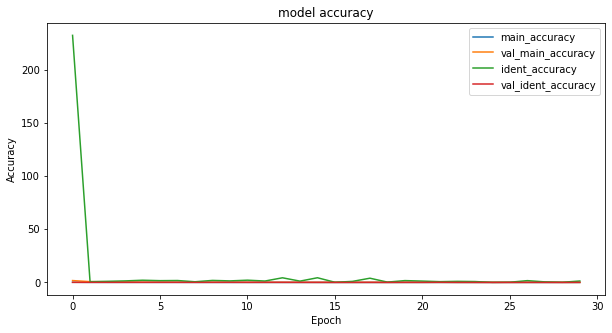

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
#plt.plot(history.history["main_accuracy"])
#plt.plot(history.history["val_main_accuracy"])
#plt.plot(history.history["ident_accuracy"])
#plt.plot(history.history["val_ident_accuracy"])
plt.plot(history.history['ident_loss'])
plt.plot(history.history['main_loss'])
plt.plot(history.history['val_main_loss'])
plt.plot(history.history['val_ident_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["main_accuracy","val_main_accuracy","ident_accuracy",'val_ident_accuracy',"main_loss",'val_main_loss',
            'ident_loss','val_ident_loss'])
plt.show()

In [82]:
def get_class_activation_map(model, img):
    ''' 
    this function computes the class activation map
    
    Inputs:
        1) model (tensorflow model) : trained model
        2) img (numpy array of shape (224, 224, 3)) : input image
    '''
    # predict to get the winning class
    predictions = model.predict(img)
    predictions=(predictions[1])[0]
    label_index = np.argmax(predictions)
    
    # Get the 2048 input weights to the softmax of the winning class.
    class_weights = model.layers[-1].get_weights()[0]
    class_weights_winner = class_weights[:, label_index]
    
    # get the final conv layer
    final_conv_layer = model.get_layer('activation_146')
    
    # create a function to fetch the final conv layer output maps (should be shape (1, 7, 7, 2048)) 
    get_output = K.function([model.layers[0].input],[final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
    
    # squeeze conv map to shape image to size (7, 7, 2048)
    conv_outputs = np.squeeze(conv_outputs)
    
    # bilinear upsampling to resize each filtered image to size of original image 
    mat_for_mult = scipy.ndimage.zoom(conv_outputs, (32, 32, 1), order=1) # dim: 224 x 224 x 2048

    # get class activation map for object class that is predicted to be in the image
    mm=scipy.ndimage.zoom(class_weights, (16,1), order=1)
    final_output = np.dot(mat_for_mult.reshape(224*224, 2048), mm).reshape(224,224) # dim: 224 x 224
    
    # return class activation map
    return final_output

In [32]:
eval_images=total_images[3000:]
eval_labels=total_labels[3000:]
eval_class_label=class_labels[3000:]

In [ ]:
from keras.models import load_model
from PIL import Image
images = eval_images
model = load_model("SBDN_CAM_model.h5")
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [34]:
ground_truth_total=eval_labels/255.0
def get_iou_score(true_label, y_pred_label):
  iou_scores=[]
  for i in range(0,len(true_label)):
    #true_label = eval_labels[i]/255.0
    pp=np.where(((predictions[i])[0])[0]>0.5,1.0,0.0)
    pp=reshape(pp,[224,224,3])
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(true_label[i],pp)
    iou_scores.append(m.result().numpy())
  return mean(iou_scores)
iou_score= get_iou_score(ground_truth_total,predictions)
print('Average Intersection over Union IoU for Blur Detection: ',iou_score )

Average Intersection over Union IoU for Blur Detection:  0.4714216


1/1 [==============================] - 0s 23ms/step
(128, 1)
(128,)
(1, 7, 7, 2048)
(1, 1)
(7, 7, 2048)
(224, 224, 2048)
(50176, 2048)
(224, 224)


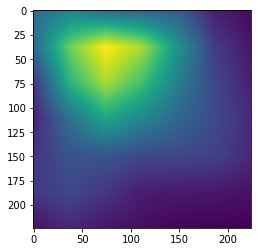

In [79]:
from keras.models import load_model
from keras import backend as K
import scipy
from PIL import Image
images = eval_images
img = images[2]
img = img.astype(np.float32)/ 255.0
img = np.expand_dims(img, -1)
img = np.expand_dims(img, 0)
pr= model.predict(img)
pr=((pr[1])[0])[0]
label_index = np.argmax(pr)
class_weights = model.layers[-1].get_weights()[0]
print(class_weights.shape)
class_weights_winner = class_weights[:, label_index]
print(class_weights_winner.shape)
final_conv_layer = model.get_layer('activation_146')
get_output = K.function([model.layers[0].input],[final_conv_layer.output, model.layers[-1].output])
[conv_outputs, pr] = get_output([img])
print(conv_outputs.shape)
print(pr.shape)
conv_outputs = np.squeeze(conv_outputs)
print(conv_outputs.shape)
mat_for_mult = scipy.ndimage.zoom(conv_outputs, (32, 32, 1), order=1)
print(mat_for_mult.shape)
aa=mat_for_mult.reshape(224*224, 2048)
print(aa.shape)
mm=scipy.ndimage.zoom(class_weights, (16,1), order=1)
ll=np.dot(aa,mm)
final_output = ll.reshape(224,224)
print(final_output.shape)
plt.imshow(final_output)

In [ ]:
from keras.models import load_model
from keras import backend as K
import scipy
from PIL import Image
images = eval_images
model = load_model("SBDN_CAM_model.h5")
class_activation_map=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  ss=get_class_activation_map(model, img)
  class_activation_map.append(ss)

In [85]:
len(class_activation_map)

338

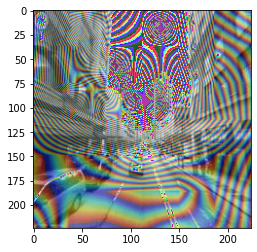

In [93]:
import matplotlib.cm as cm
alpha=0.4
heatmap = np.uint8(255 * class_activation_map[1])
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((images[1].shape[1], images[1].shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
superimposed_img = jet_heatmap * alpha + images[1]
superimposed_img.shape
plt.imshow(superimposed_img.astype(np.uint8))


predicted class vs true class


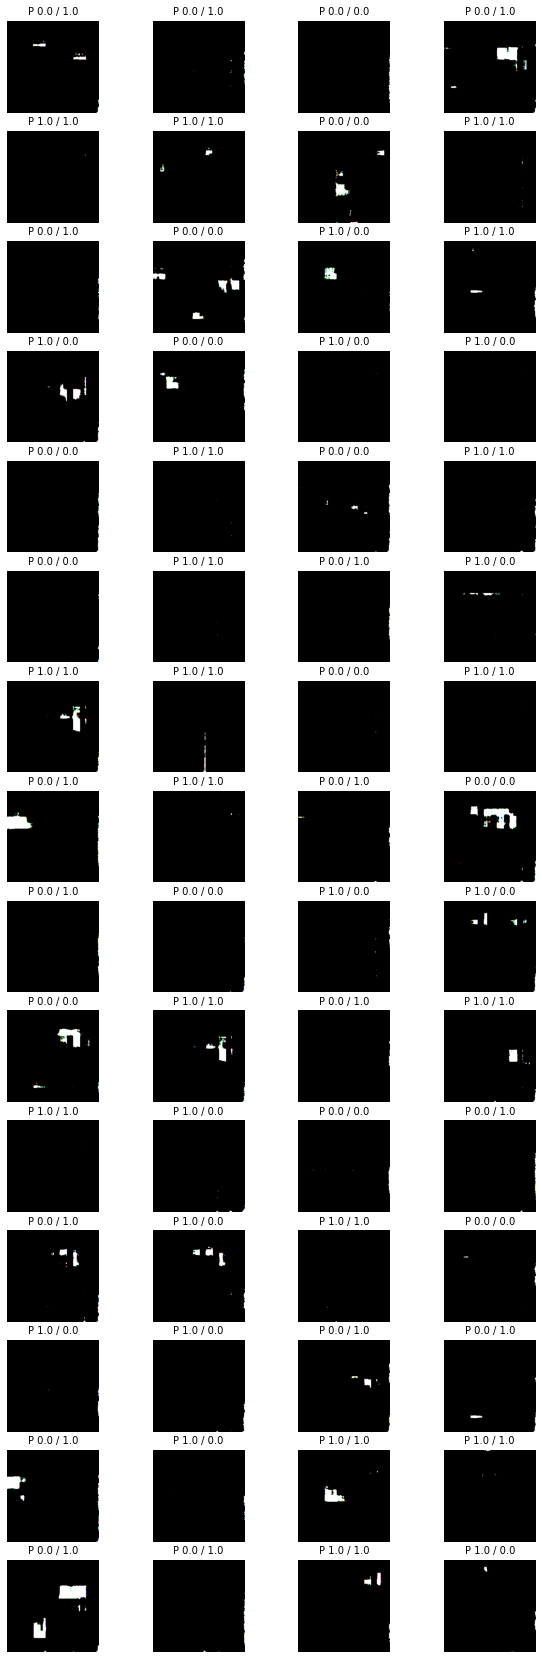

In [35]:
columns = 4
rows = 15
print("predicted class vs true class")
fig = plt.figure(figsize=(10,30))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where((((predictions[i])[0])[0])>0.5,1.0,0.0)
  plt.imshow((img_pred_label*255.0).astype(np.uint8))
  predicted_class=(((predictions[i])[1])[0])[0]
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  plt.title(f"P {predicted_class} / {eval_class_label[i]}",fontsize=10)
  plt.axis("off")
plt.show()

predicted class vs true class


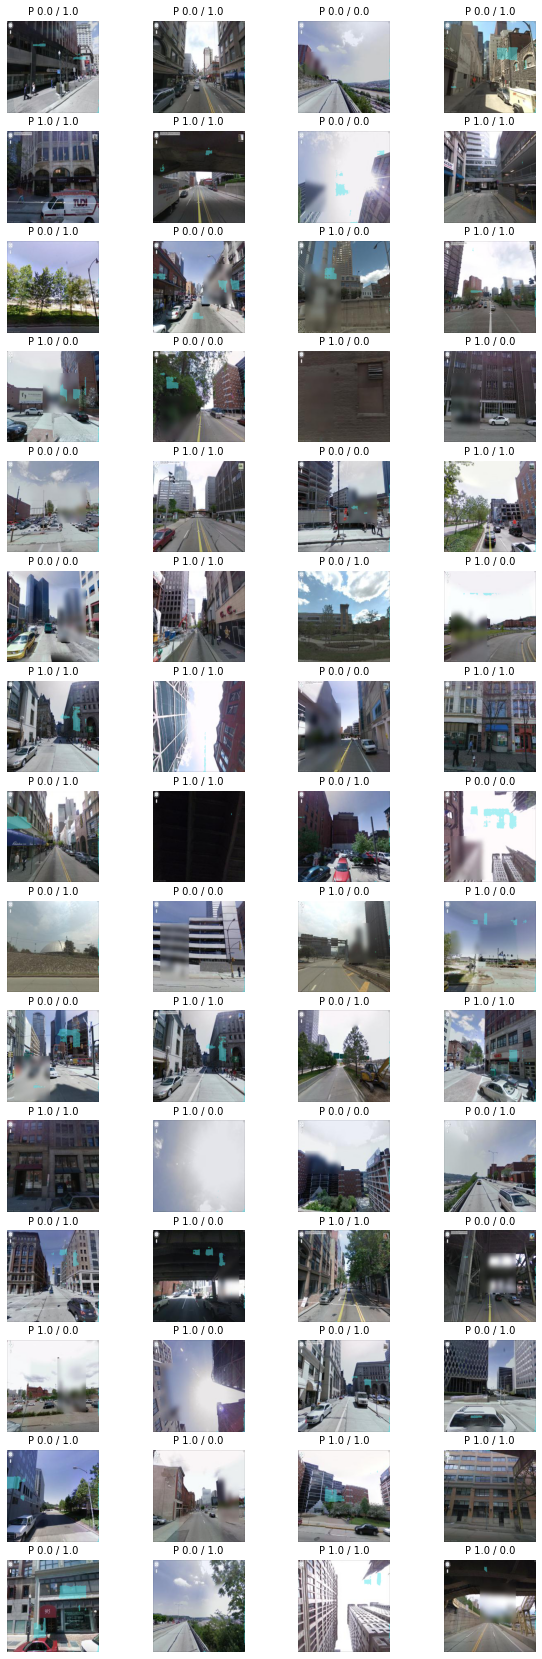

In [31]:
fig = plt.figure(figsize=(10,30))
columns = 4
rows = 15
print("predicted class vs true class")
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where((((predictions[i])[0])[0])>0.5,1.0,0.0)
  mask=(img_pred_label*255.0).astype(np.uint8)
  blackFrame = np.zeros((224,224, 3), dtype = "uint8")
  whiteFrame = 255 * np.ones((224,224,3), np.uint8)
  #label_img = Image.fromarray(label_img)
  mask = np.where(mask==255,whiteFrame,blackFrame)
  img= images[i]
  cyan = np.full_like(img,(80, 229, 235))
  blend = 0.5
  img_cyan = cv2.addWeighted(img, blend, cyan, 1-blend, 0)
  mask = np.where(mask>=165,img_cyan,img)
  #mask =cv2.cvtColor(mask , cv2.COLOR_BGR2RGB)
  plt.imshow(mask,cmap='binary')
  #mask = Image.fromarray(mask)
  predicted_class=(((predictions[i])[1])[0])[0]
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  plt.title(f"P {predicted_class} / {eval_class_label[i]}",fontsize=10)
  plt.axis("off")
plt.show()

predicted class vs true class


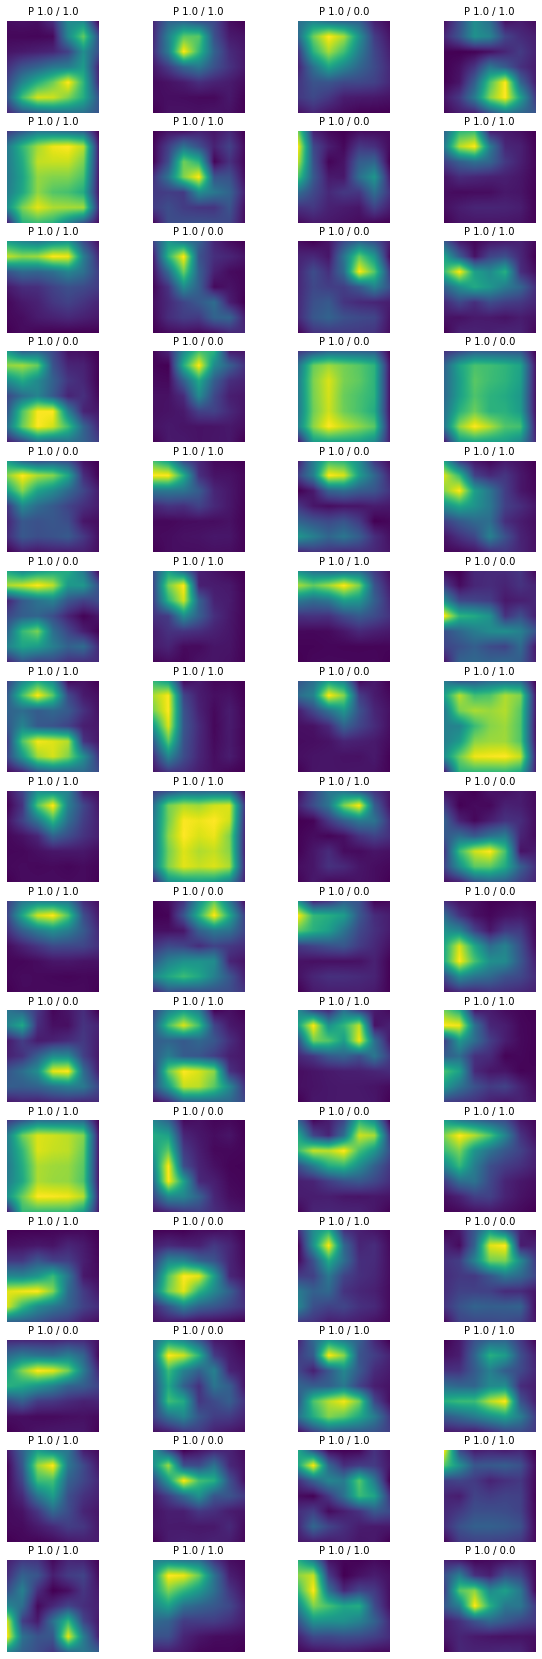

In [98]:
columns = 4
rows = 15
print("predicted class vs true class")
fig = plt.figure(figsize=(10,30))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(class_activation_map[i])
  plt.title(f"P {predicted_class} / {eval_class_label[i]}",fontsize=10)
  plt.axis("off")
plt.show()